**Brief Overview:**

* For this project, I am supposed to be an ML Engineer/Data Scientist that was tasked to provide a model for predicting housing prices given a set of features (i.e., bedrooms, number of bathrooms, floor area, and land area)
* My approach was to perform a streamlined process of performing model training and hyperparameter optimization so I can look at the MSE and distribution of target and predicted values of each model to determine which is the best.
* The models that I chose for this project from scikit-learn are the following: SVR, MLPRegressor, RandomForestRegressor
* Note: No feature selection was performed. I am planning to do a fit with RandomForestRegression and acquiring the feature importances. If you have better suggestions on performing this, feel free to suggest.

Thank you!

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer

In [4]:
DATASET_INTERIM_PATH = r"data\interim"
MODELS_PATH = r"models"

In [5]:
df = pd.read_csv(os.path.join("..", DATASET_INTERIM_PATH, 'cleaned_data.csv'))

In [6]:
df_copy = df.copy()
df_copy.drop(['Region'], axis=1, inplace=True)

In [7]:
df_copy.head()

,Price,Bedrooms,Bathrooms,Floor Area,Land Area,Urbanicity
0,9500000.0,4.0,3.0,144.00,136.0,Urban
1,4400000.0,3.0,2.0,63.20,80.0,Urban
2,7810000.0,5.0,3.0,100.00,110.0,Urban
3,3275000.0,2.0,1.0,40.32,78.4,Urban
4,1800000.0,2.0,2.0,52.00,40.0,Urban


# Train-Valid-Test Split

* For this step, I decided to set a hold-out test split to determine the performance of the models on unseen data.
* First, I splitted the whole dataset on train and test data (80-20 ratio respectively).
* Second, I splitted the train data into train data and valid data (80-20 ratio respectively).

In [8]:
X = df_copy.drop(['Price'], axis=1)
y = df_copy['Price']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
print(f"Shape of Training Data: {X_train.shape}")
print(f"Shape of Validating Data: {X_valid.shape}")
print(f"Shape of Testing Data: {X_test.shape}")

Shape of Training Data: (846, 5)
Shape of Validating Data: (212, 5)
Shape of Testing Data: (265, 5)


# Training / Hyperparameter Optimization and Evaluation

## Training / Hyperparameter Optimization

In [12]:
stacking_regressor_estimators = [('svm', SVR()), ('random_forest', RandomForestRegressor(random_state=42))]

# Models dictionary
models = {
    'svm' : SVR(),
    'random_forest' : RandomForestRegressor(random_state=42),
    'stacking' : StackingRegressor(
        estimators=stacking_regressor_estimators,
        final_estimator=DecisionTreeRegressor(random_state=42)
    )
}

In [13]:
# Parameter Distributions for each model
param_distributions = {
  "svm" : {
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf", "poly"],
    "model__gamma": [0.01, 0.1, 1],  # Hyperparameter for rbf and poly kernels
    "model__epsilon": [0.001, 0.01, 0.1],  # Insensitivity parameter
    "model__degree": [2, 3, 4]  # Degree for poly kernel (if applicable)
  },

  "random_forest" : {
    "model__n_estimators": [100, 200, 300],  # Number of trees in the forest
    "model__max_depth": [5, 10, 15],  # Maximum depth of each tree
    "model__min_samples_split": [2, 5, 10],  # Min samples required to split a node
    "model__min_samples_leaf": [1, 5, 10],  # Min samples allowed in a leaf node
    "model__max_features": ["sqrt", "log2", 1.0]  # Max features considered at each split
  },

  "stacking" : {
    "model__svm__C": [0.1, 1, 10],
    "model__svm__kernel": ["linear", "rbf", "poly"],
    "model__svm__gamma": [0.01, 0.1, 1],  # Hyperparameter for rbf and poly kernels
    "model__svm__epsilon": [0.001, 0.01, 0.1],  # Insensitivity parameter
    "model__svm__degree": [2, 3, 4],  # Degree for poly kernel (if applicable)
    "model__random_forest__n_estimators": [100, 200, 300],  # Number of trees in the forest
    "model__random_forest__max_depth": [5, 10, 15],  # Maximum depth of each tree
    "model__random_forest__min_samples_split": [2, 5, 10],  # Min samples required to split a node
    "model__random_forest__min_samples_leaf": [1, 5, 10],  # Min samples allowed in a leaf node
    "model__random_forest__max_features": ["sqrt", "log2", 1.0]  # Max features considered at each split
  }
}

In [14]:
# Function that will be used to perform log transformation on numerical features
def log_transform(x):
    return np.log(x)

In [15]:
categorical_cols = ['Urbanicity'] # Categorical Column(s) / Feature(s)
numerical_cols = [col for col in X_train.columns if col not in categorical_cols] # Numerical Column(s) / Feature(s)

In [14]:
## Custom function for Root Mean Squared Logarithmic Error (RMSLE) scorer
## Converts negative values into 1 by using np.clip to avoid error during logarithmic transformation
## Not sure if the method is okay to use so I might use the built in "neg_mean_absolute_error" which is the Mean Absolute Error from scikit-learn regression metrics
## At least,

# def func_rmsle(y_true, y_pred):
#     # return np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_true + 1)) ** 2))
#     return np.sqrt(np.mean((np.log(np.clip(y_pred, 1, np.inf)) - np.log(y_true + 1))**2))

# rmsle = make_scorer(func_rmsle, greater_is_better=False)

In [18]:
# Dataframe to store the training and hyperparameter optimization results
model_scores_and_params_df = pd.DataFrame(
    columns=['svm', 'random_forest', 'stacking'], 
    index=['best_score', 'best_params', 'training_score', 'validation_score', 'testing_score']
)

# Dictionary to store the fitted model pipelines
model_pipelines = {
    'svm' : None,
    'random_forest' : None,
    'stacking' : None
}

# Apply 5-folds for cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through each model to perform RandomizedSearchCV
for model_name, model in models.items():
    print(f"Performing RandomizedSearchCV for {model_name}")
    params = param_distributions[model_name] # param_distribution for each model
    
    pipeline = Pipeline([
        ('preprocess', 
            ColumnTransformer(
                transformers=[
                        ('log', FunctionTransformer(log_transform), numerical_cols), # Log transformation
                        ('scaler', RobustScaler(), numerical_cols),  # Standardization
                        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols) # One-Hot Encoding
                    ], remainder='passthrough')),
        ('model', model)
    ])

    estimator = RandomizedSearchCV(estimator=pipeline, param_distributions=params, scoring='neg_mean_absolute_error', cv=kf, random_state=42)
    estimator.fit(X_train, y_train)

    # Record and store the result metrics and best params
    best_score = -1 * (estimator.best_score_)
    best_params = estimator.best_params_
    training_score = -1 * (estimator.score(X_train, y_train))
    validation_score = -1 * (estimator.score(X_valid, y_valid))
    testing_score = -1 * (estimator.score(X_test, y_test))

    model_scores_and_params_df.loc['best_score', model_name] = best_score
    model_scores_and_params_df.loc['best_params', model_name] = str(best_params)
    model_scores_and_params_df.loc['training_score', model_name] = training_score
    model_scores_and_params_df.loc['validation_score', model_name] = validation_score
    model_scores_and_params_df.loc['testing_score', model_name] = testing_score

    # Store the pipeline with the best params set
    best_model_pipeline = pipeline.set_params(**best_params)
    best_model_pipeline.fit(X_train, y_train)
    model_pipelines[model_name] = best_model_pipeline

Performing RandomizedSearchCV for svm
Performing RandomizedSearchCV for random_forest
Performing RandomizedSearchCV for stacking


* During some of the MLP instances did not converge despite of setting `max_iter=1000`
* `UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros` is an error that I think was caused by the absence of some regions in either training, validation, or testing split during the fit.

Question: Are these errors negligible?

## Evaluation

In [19]:
model_scores_and_params_df

,svm,random_forest,stacking
best_score,17093547.856248,14592952.254969,17599186.299977
best_params,"{'model__kernel': 'poly', 'model__gamma': 1, '...","{'model__n_estimators': 300, 'model__min_sampl...","{'model__svm__kernel': 'linear', 'model__svm__..."
training_score,14661925.562265,7960678.453617,16416901.044917
validation_score,14624728.563326,16087218.257165,20292171.15566
testing_score,20356029.555272,18886265.787366,25594270.539623


* The housing prices ranges in the dataset ranges from hundred thousands to billions that is why the magnitude of the score, which is mean squared error (MSE), is also large.
* Based on the test scores, the order from best performing to least is: mlp > random_forest > svm

In [78]:
def plot_target_vs_predictions(ax, model_name, X, y, x_max_add=0, y_max_add=0):
    # plt.figure(figsize=(10, 5))

    predictions = model_pipelines[model_name].predict(X)

    # Find axes limits (min and max)
    x_min = min(predictions)
    x_max = max(predictions) + x_max_add  # Adjust accordingly to improve scatterplot presentation, same with y_max
    y_min = min(y)
    y_max = sorted(y, reverse=True)[1] + y_max_add # Getting the second to the largest test target removes the 2.5B pesos house price

    # Set the axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.scatter(predictions, y, s=10)
    ax.plot(y, y, color='red', linewidth=0.5, label='target line')
    ax.set_xlabel("prediction")
    ax.set_ylabel("target")
    ax.set_title(f"Predictions vs Target ({model_name})")
    ax.legend()

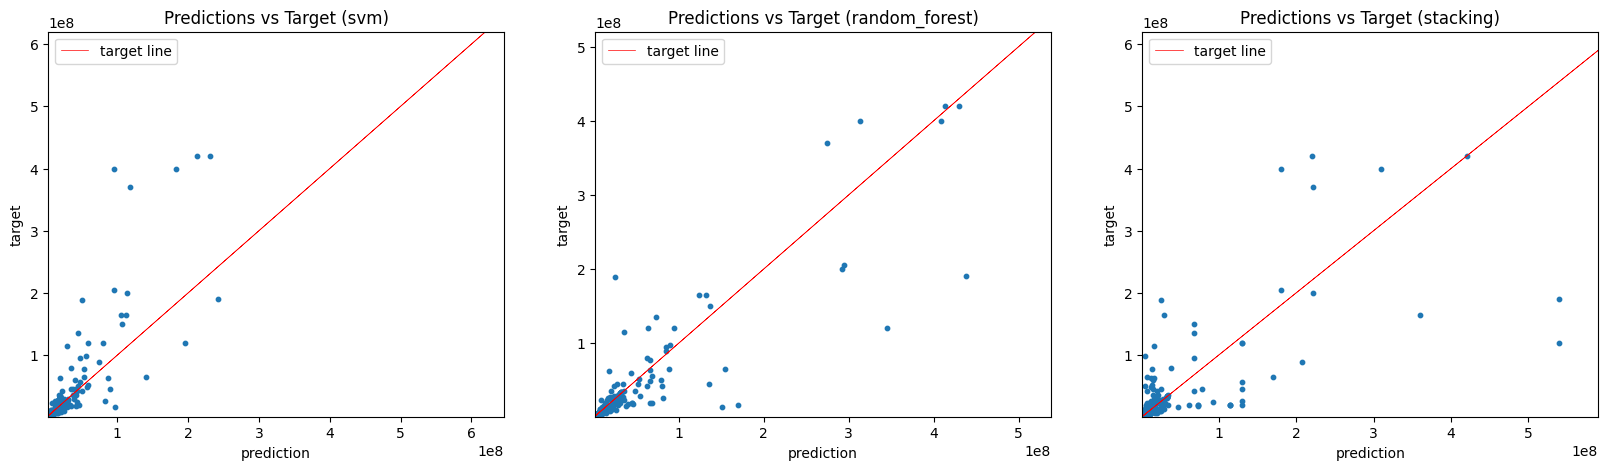

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_target_vs_predictions(axes[0], "svm", X_test, y_test, x_max_add=0, y_max_add=200000000)
plot_target_vs_predictions(axes[1], "random_forest", X_test, y_test, x_max_add=100000000, y_max_add=100000000)
plot_target_vs_predictions(axes[2], "stacking", X_test, y_test, x_max_add=50000000, y_max_add=200000000)

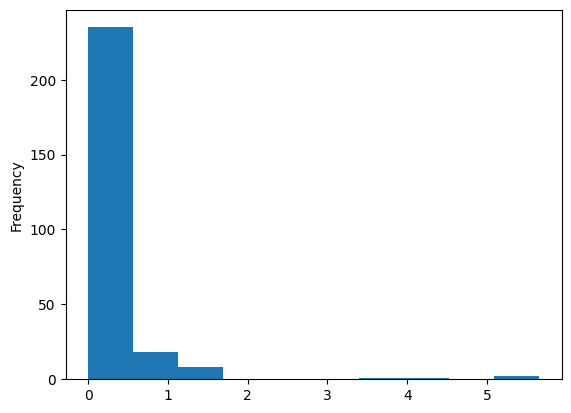

In [22]:
def log_error(y_true, y_pred):
    return (np.log(y_pred + 1) - np.log(y_true +1))**2

log_error(y_test, model_pipelines['random_forest'].predict(X_test)).plot(kind='hist')
plt.show()

* Ask in Discord if okay lang yung log_error() function as the method to get the residuals to plot since the scale of the target value is large. It is derived from RMSLE

# Plotting Targets and Predictions Distribution (omitted)

In [252]:
# Helper function to visualize the difference between the target and predicted values
# Set loga=True if to visualize in log units
def plot_distribution(X, y, model_name, ax, split_name, loga=False):
    predictions = model_pipelines[model_name].predict(X)
    
    if loga:
        y = np.log(y)
        predictions = np.log(predictions)
        title = f"{model_name} - {split_name} (log)"
    else: 
        title = f"{model_name} - {split_name}"

    ax.set_title(title)
    ax.hist((y), color='blue', alpha=0.5, label='true')
    ax.hist(predictions, color='red', alpha=0.5, label='prediction')
    ax.legend()

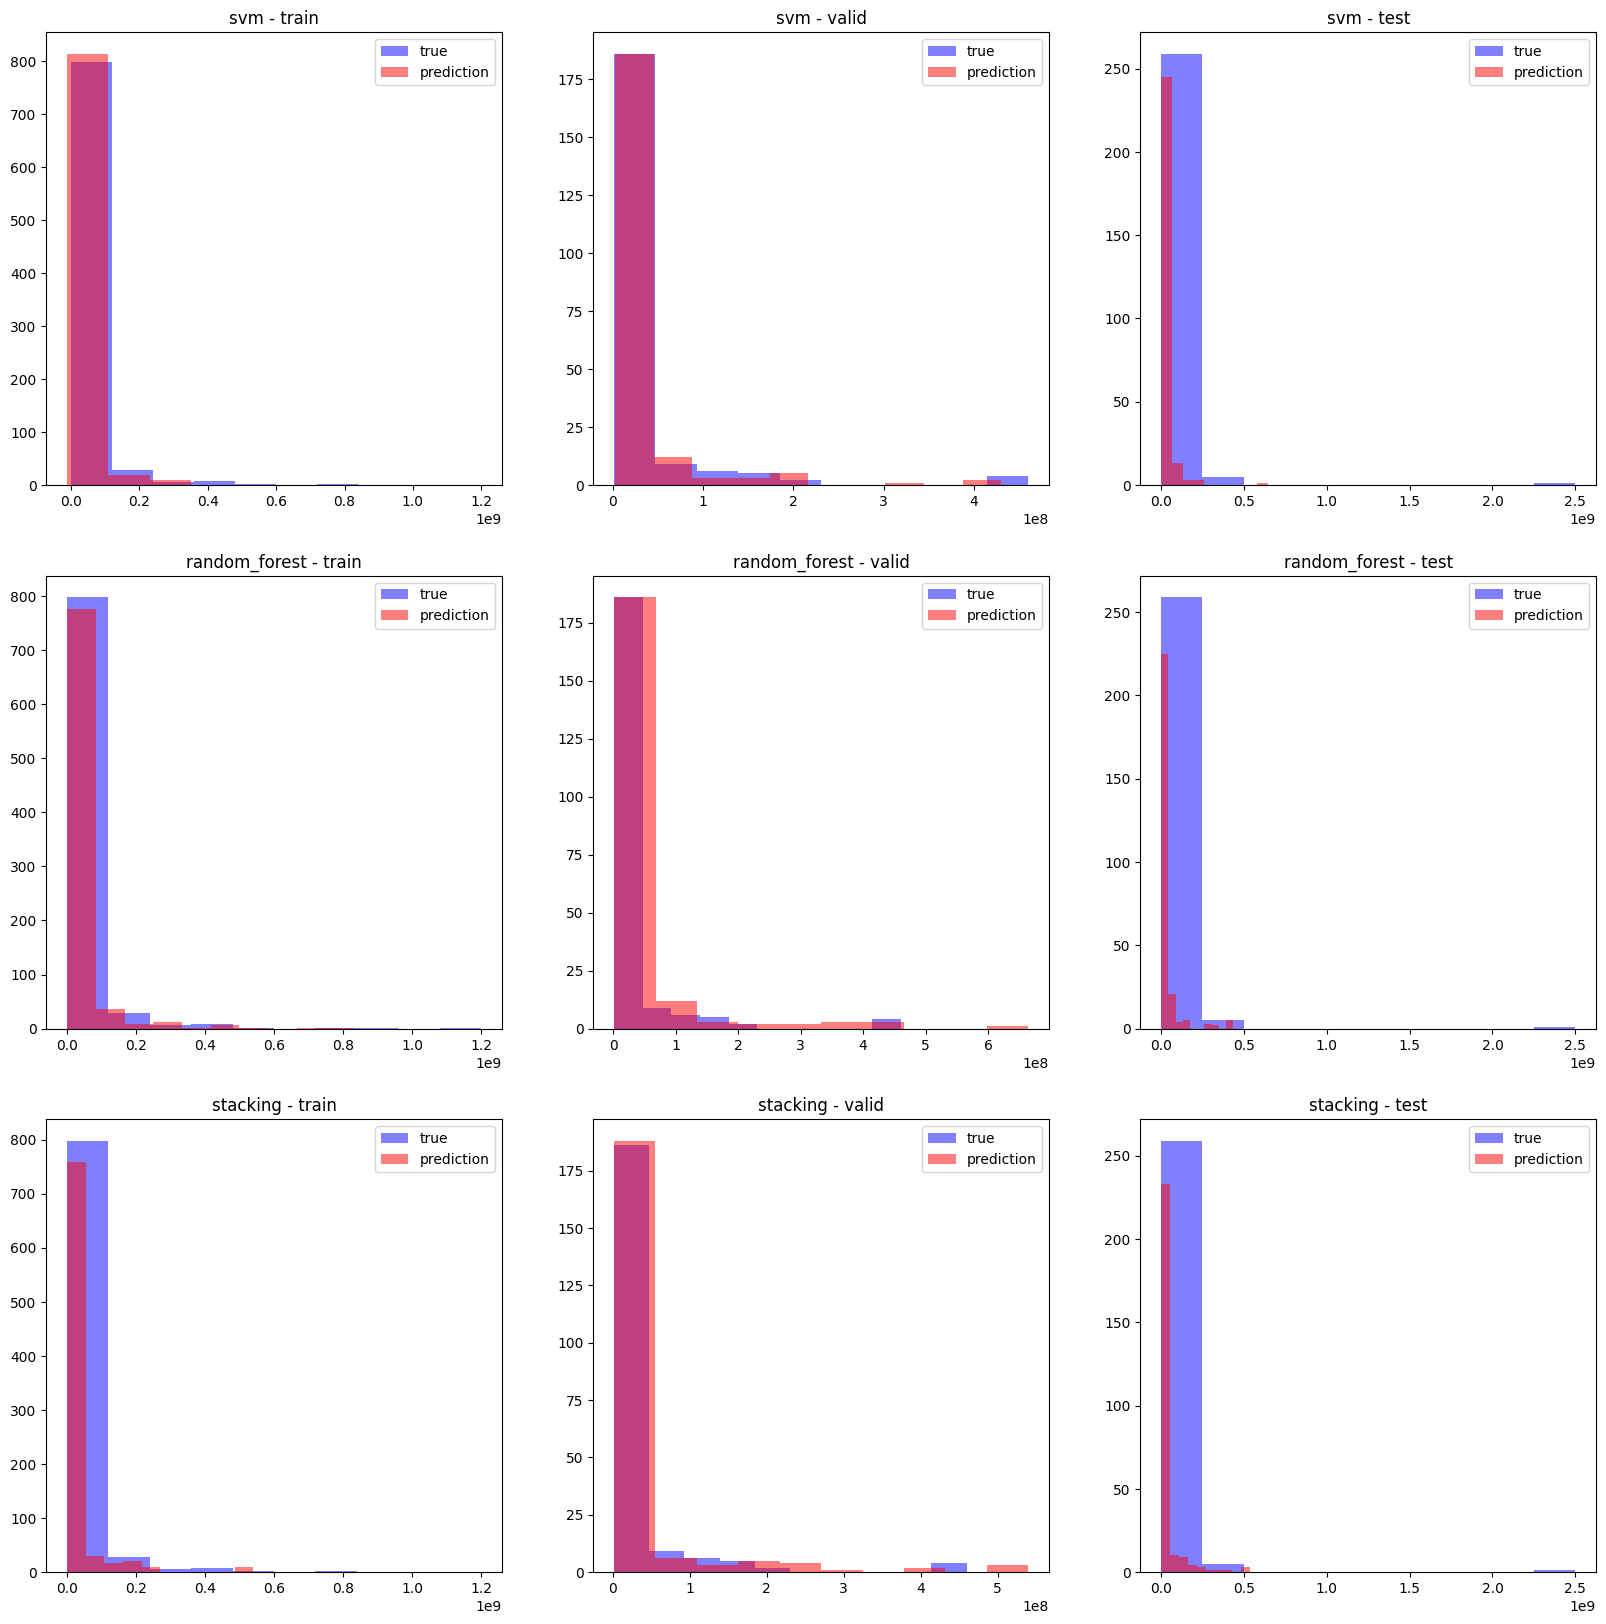

In [253]:
# Distribution visualization in normal units
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

data = [
    (X_train, y_train, 'train'), (X_valid, y_valid, 'valid'), (X_test, y_test, 'test')
]

for row, model_name in enumerate(models.keys()):
    for col, split in zip(range(3), data):
        plot_distribution(split[0], split[1], model_name, axes[row, col], split[2], loga=False)

plt.show()

C:\Users\Jco\AppData\Local\Temp\ipykernel_18128\208662834.py:8: RuntimeWarning: invalid value encountered in log
  predictions = np.log(predictions)


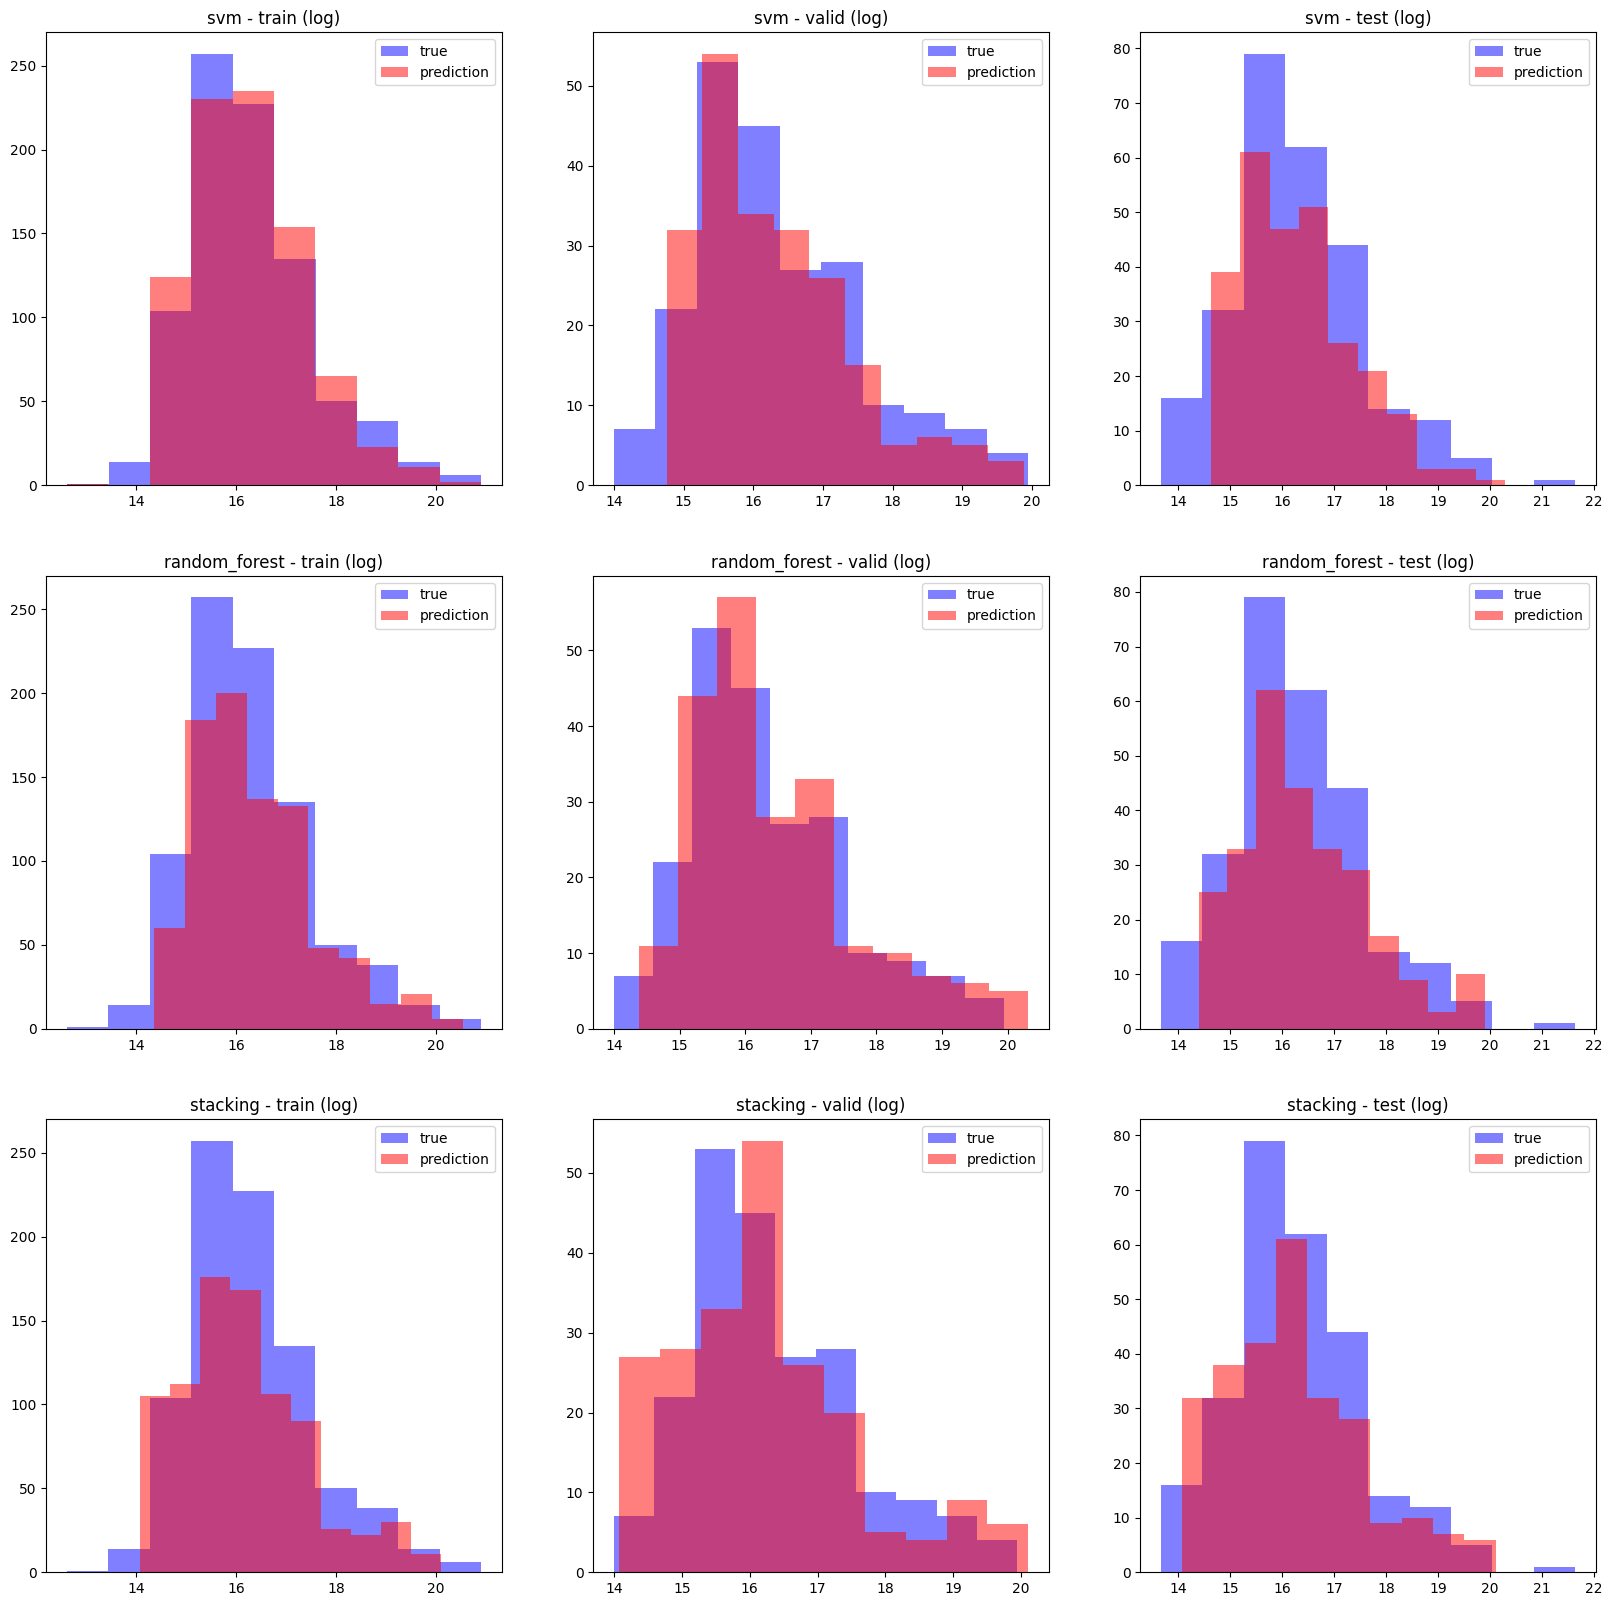

In [254]:
# Distribution visualization in log units
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for row, model_name in enumerate(models.keys()):
    for col, split in zip(range(3), data):
        plot_distribution(split[0], split[1], model_name, axes[row, col], split[2], loga=True)

plt.show()

* Based on the visualization of distributions of test targets and predictions, **MLP** seems to have the largest overlapping region with the true/target values which can be seen clearly on the log representation which further supports its MSE as the least among the three models.
* Thus, it is the best model (with its optimal parameters from hyperparamter tuning) and shall be used for deployment.

Question: Is it okay for me to perform log transformation to the target and predictions to clearly visualize the distributions? Only for the visualization to see the overlapping clearly.

# Saving the models

In [30]:
def save_model(save_path, model, model_name, version):
    try:
        filename = f"{model_name}-{version}.pkl"
        destination = os.path.join("..", save_path, filename)
        joblib.dump(model, destination)
        print(f"Saved in {destination}")
    except:
        print(f"Error saving model for {model_name}")

In [31]:
for model_name, model in model_pipelines.items():
    save_model(MODELS_PATH, model_pipelines[model_name], f'{model_name}.pkl', 'v1')

Saved in ..\models\svm.pkl-v1.pkl
Saved in ..\models\random_forest.pkl-v1.pkl
Saved in ..\models\mlp.pkl-v1.pkl


In [ ]:
# model_pipelines['random_forest'].predict(pd.DataFrame(X_test.iloc[0]).transpose()) # For predicting a single set of features